In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from help_functions.evaluate_daxmodels import evaluate_different_daxmodels

from dax.help_functions.get_dax_data import get_prepared_data
from dax.models.time_series_models.garch11_norm import get_garch_11_norm
from dax.models.time_series_models.garch11_t import get_garch_11_t
from dax.models.time_series_models.ar_garch import get_garch_11_ar
from dax.models.baseline import get_dax_forecasts_baseline
from dax.models.quantile_regression import get_quantile_regression_forecasts
from dax.models.combination.combined_models import combine_models

In [2]:
dax_df = get_prepared_data()
dax_df

,Close,LogRetLag1,LogRetLag2,LogRetLag3,LogRetLag4,LogRetLag5
Date,,,,,,
2019-09-10 00:00:00+02:00,12268.709961,0.347914,0.629422,1.163586,2.006097,2.960150
2019-09-11 00:00:00+02:00,12359.070312,0.733812,1.081725,1.363234,1.897398,2.739909
2019-09-12 00:00:00+02:00,12410.250000,0.413251,1.147063,1.494977,1.776485,2.310649
2019-09-13 00:00:00+02:00,12468.530273,0.468515,0.881766,1.615578,1.963491,2.245000
2019-09-16 00:00:00+02:00,12380.309570,-0.710062,-0.241547,0.171704,0.905516,1.253429
...,...,...,...,...,...,...
2023-11-16 00:00:00+01:00,15786.610352,0.243797,1.096667,2.837245,3.560679,2.788120
2023-11-17 00:00:00+01:00,15919.160156,0.836129,1.079926,1.932796,3.673374,4.396808
2023-11-20 00:00:00+01:00,15901.330078,-0.112067,0.724062,0.967860,1.820729,3.561307


In [3]:
# check if functions work
baseline = {
    'name': 'baseline',
    'function': get_dax_forecasts_baseline
}
quantile_regression = {
    'name': 'Quantile Regression',
    'function': get_quantile_regression_forecasts
}
garch_tt = {
    'name': 'garch11_t',
    'function': get_garch_11_t
}
combined = {
    'name': 'combined',
    'function': combine_models
}

models = [baseline, quantile_regression, garch_tt, combined] 

In [4]:
combine_models()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18782.929938468144
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2689.396426270799
Iteration:      3,   Func. Count:     21,   Neg. LLF: 2872.2883131688286
Iteration:      4,   Func. Count:     27,   Neg. LLF: 2512.040632240171
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1633.5781288697367
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1655.1444975931322
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1631.0196478993641
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1630.9670678627122
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1630.9531726086493
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1630.9463208455136
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1630.9462284599172
Iteration:     12,   Func. Count:     70,   Neg. LLF: 1630.9462256026227
Iteration:     13,   Func. Count:     74,   Neg. LLF: 1630.9462256026231
Optimization terminated successfully    (Exit mode 0)

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
date_time,,,,,,,,
2023-11-23,2023-11-22,DAX,1 day,-2.808526,-0.557092,0.036569,0.666377,2.474589
2023-11-24,2023-11-22,DAX,2 day,-3.279446,-0.749939,0.066022,0.861853,3.065384
2023-11-27,2023-11-22,DAX,5 day,-4.411144,-0.922610,0.136412,1.155700,4.117264
2023-11-28,2023-11-22,DAX,6 day,-5.218509,-1.115445,0.133844,1.418841,4.585514
2023-11-29,2023-11-22,DAX,7 day,-5.652658,-1.222586,0.217925,1.543300,5.140368


In [5]:
evaluation = evaluate_different_daxmodels(models,dax_df, last_x=10, years=False, months=False, weeks=True)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19187.810829823677
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2683.691482590828
Iteration:      3,   Func. Count:     21,   Neg. LLF: 2866.1032025603454
Iteration:      4,   Func. Count:     27,   Neg. LLF: 2506.8216688069992
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1629.238837284029
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1642.6823954635202
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1626.8315182494764
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1626.782301261982
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1626.7682517399799
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1626.7618873652577
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1626.761776963839
Iteration:     12,   Func. Count:     70,   Neg. LLF: 1626.7617730118902
Iteration:     13,   Func. Count:     74,   Neg. LLF: 1626.7617730118893
Optimization terminated successfully    (Exit mode 0)
 

## Visualize Comparsion

In [13]:
models[1]['evaluation']

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975,observation,score
date_time,,,,,,,,,,
2023-11-16,2023-11-15,DAX,1 day,-2.947308,-0.537473,0.07543,0.728021,2.505007,0.243797,1.073730
2023-11-17,2023-11-15,DAX,2 day,-3.56162,-0.718187,0.095647,0.904098,3.265233,1.079926,2.488421
2023-11-20,2023-11-15,DAX,5 day,-4.383176,-0.812306,0.202216,1.133297,4.061466,0.96786,2.160677
2023-11-21,2023-11-15,DAX,6 day,-4.905169,-0.872444,0.203277,1.351599,3.996575,0.96283,2.316661
2023-11-22,2023-11-15,DAX,7 day,-5.278834,-0.875907,0.311634,1.371002,4.033495,1.322485,2.599922
2023-11-09,2023-11-08,DAX,1 day,-2.758764,-0.496439,0.052851,0.658277,2.345975,0.804006,1.875208
2023-11-10,2023-11-08,DAX,2 day,-3.305108,-0.658603,0.104912,0.805921,3.000135,0.031447,1.120989
2023-11-13,2023-11-08,DAX,5 day,-4.091035,-0.756242,0.215473,1.081601,3.818845,0.754881,1.853824
2023-11-14,2023-11-08,DAX,6 day,-4.574275,-0.810249,0.19332,1.297134,3.62782,2.495459,6.162585


In [7]:
# create table only containing different scores of different models

horizons = ['1 day', '2 day', '5 day', '6 day', '7 day']
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score']
                      [m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1, keys=names)

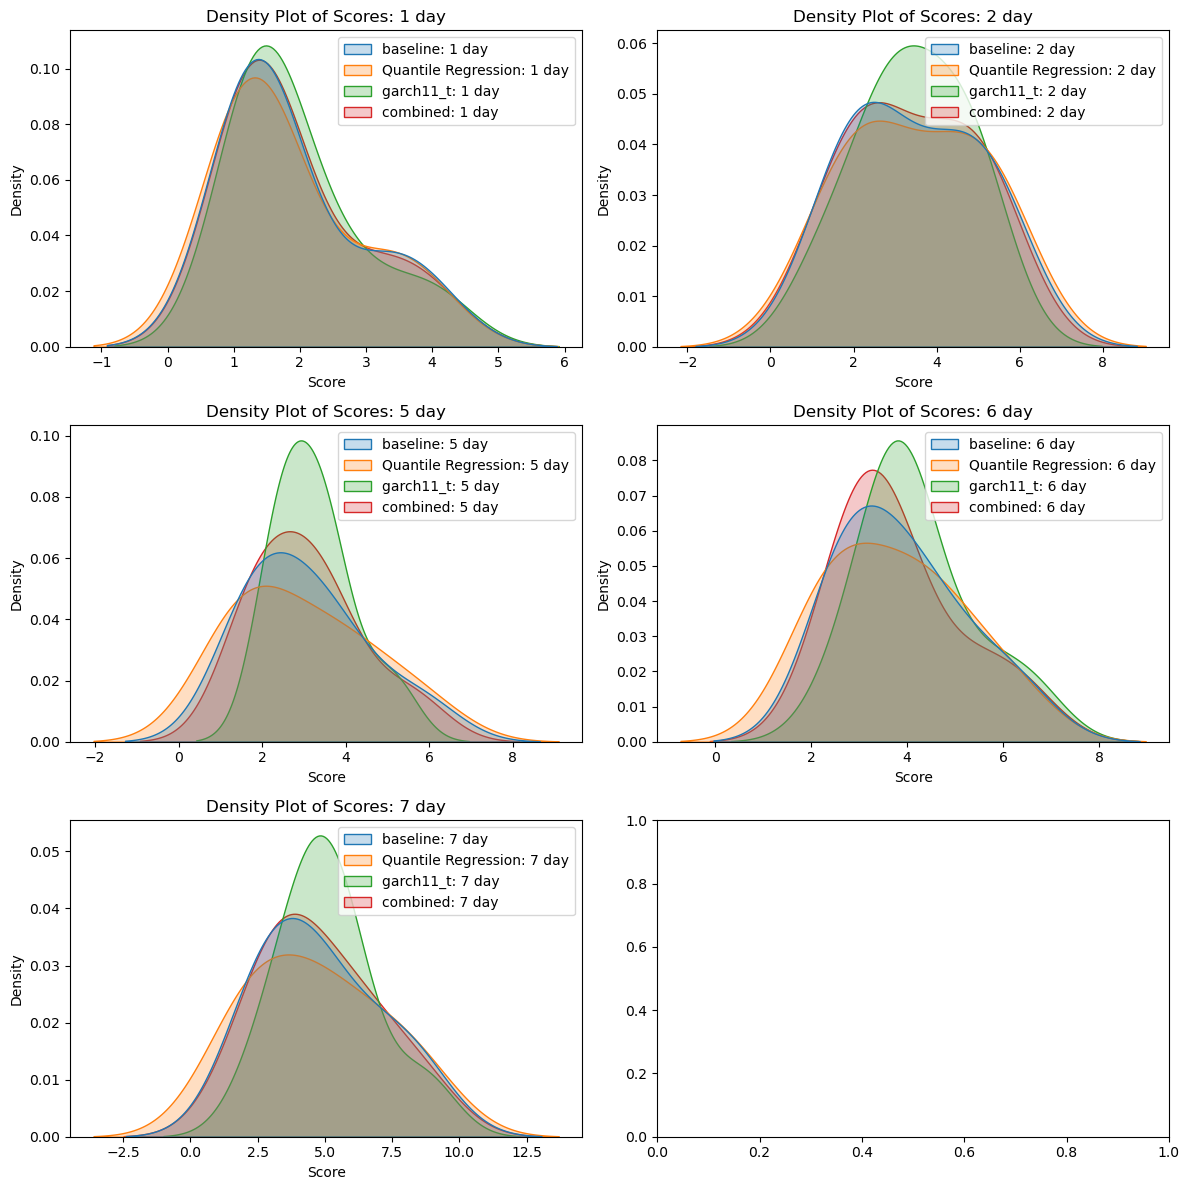

In [8]:
# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Loop through each horizon
for i, h in enumerate(horizons):
    # Select columns related to the current horizon
    relevant_cols = [f'{m["name"]}: {h}' for m in models]

    # Filter the relevant data for the current horizon
    data_subset = score_df.loc[:, relevant_cols]

    # Create a KDE plot for the current horizon
    sns.kdeplot(data=data_subset, fill=True, ax=axes[i])

    # Set labels and title for each subplot
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Density Plot of Scores: {h}')

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Display the plots
plt.show()

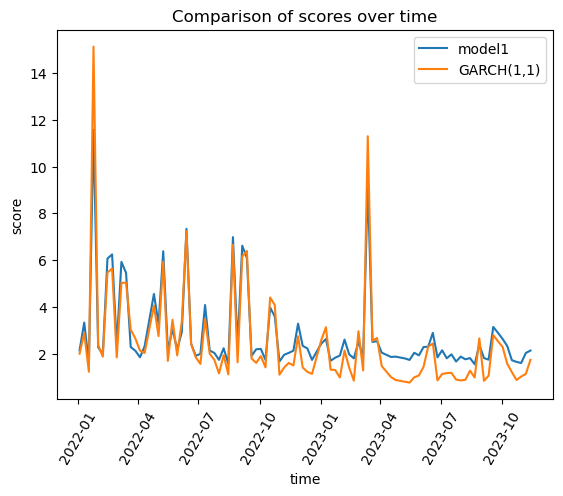

In [9]:
# Plot values from two columns over time
score_df_1d_no_na = score_df[score_df['model1: 5 day'].notna()]
score_df_garch_no_na = score_df[score_df['GARCH(1,1) model: 5 day'].notna()]

plt.plot(score_df_1d_no_na.index,
         score_df_1d_no_na['model1: 5 day'], label='model1')
plt.plot(score_df_garch_no_na.index, score_df_garch_no_na['GARCH(1,1) model: 5 day'], label='GARCH(1,1)')

# Adding labels and title
plt.xlabel('time')
plt.xticks(rotation=60)
plt.ylabel('score')
plt.title('Comparison of scores over time')

# Display legend
plt.legend()

# Show the plot
plt.show()

### Interpretation
GARCH(1,1) better than baseline (model1). 